In [1]:
!pip3 install -U scikit-fuzzy

  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894074 sha256=eb2d56baf74c374422cead3c61b107c91a3385f2281003abdb4216211c16a3b3
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\2c\04\80\7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy


In [1]:
import random
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
# the simulated price table
# VCPU 
# 0-10: 0.2€/st 1 month
# 11-30: 0.1
# 31-90: 0.05
# RAM 
# 0-20: 0.1€/per GB month
# 21-60: 0.05
# 61-180: 0.025
# VOLUME：
# 0-100：0.02€/per GB 1 month
# 101-300：0.01€/per GB 1 month
# 301-900：0.005€/per GB 1 month

In [3]:
def visualize_parameter(x_range,y_range,requirement,ylabel):
    plt.figure(figsize=[15, 5])
    x = x_range
    y = y_range
    x_diff = x_range[-1] - x_range[0]
    plt.xlim((x_range[0]-0.1*x_diff, x_range[-1]+0.1*x_diff))
    l1 = plt.plot(x, y, color='b',marker='o',linestyle='dashed',label='Provider proposal')
    #plt.axis([-5, x_range[-1]+5, requirement-10,  y_range[0]+10])
    plt.xlabel('round')
    plt.ylabel(ylabel)
    y_requirement = [requirement]*len(x_range)
    l2 = plt.plot(x, y_requirement, color='r',linestyle='dashed',label='Client requirement')
    plt.annotate('Last offer', xy=(x_range[-1],y_range[-1]), xytext=(x_range[-1],y_range[-1]-(y_range[0]-y_range[-1])*0.2),
            arrowprops=dict(facecolor='black',width=0.5, headwidth=7, shrink=0.005),
            )
    plt.legend()
    plt.show()

In [47]:
def visulaize_gain(parameter,offer_list,offer,requirement,total_fee,total_fee_old,avg,avg_old):  
    fig = plt.figure(figsize=[12, 8])
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    option = -1
    if parameter == 'vcpu':
        option = 0
    elif parameter == 'ram':
        option = 1
    elif parameter == 'storage':
        option = 2
    name_list = deepcopy(offer_list)
    name_list[-1] = 'final'
    amount_ratio = []
    fee_ratio = []
    total_fee_ax2 = []
    total_fee_ratio = []
    for i in offer_list:
        print(i)
        amount_ratio.append(offer[i]/requirement[option])
        fee_ratio.append((offer[i]*avg[i])/(requirement[option]*avg_old))
        total_fee_ratio.append(total_fee[i]/total_fee_old)
        total_fee_ax2.append(total_fee[i])
       
    x1 = list(range(len(name_list)))
    x2 = list(range(len(name_list)))
    x3 = list(range(len(name_list)))
    total_width, n = 1.1, 4
    width = total_width / n
    
    x0 = list(range(-1,len(name_list)+1))
    y_requirement = [1.0]*len(x0)
    ax1.plot(x0, y_requirement, color='r',linestyle='dashed',label='Ratio: Baseline = 1.0')
    
    for i in range(len(x1)):
        x1[i] = x1[i] - width
    ax1.bar(x1, amount_ratio, width=width, label='Ratio: Amount of '+parameter, fc='c')
    ax1.bar(x2, fee_ratio, width=width, label='Ratio: Fee of '+parameter, tick_label=name_list, fc='y')
    for i in range(len(x3)):
        x3[i] = x3[i] + width
    ax1.bar(x3, total_fee_ratio, width=width, label='Ratio: Total fee', fc='g')
    
    for a,b in zip(x1,amount_ratio):  
        ax1.text(a, b+0.02, '%.3f' % b, ha='center', va= 'bottom',fontsize=8) 
    for a,b in zip(x2,fee_ratio):  
        ax1.text(a, b+0.02, '%.3f' % b, ha='center', va= 'bottom',fontsize=8)     
    for a,b in zip(x3,total_fee_ratio):  
        ax1.text(a, b+0.02, '%.3f' % b, ha='center', va= 'bottom',fontsize=8) 
    
    
    ax2.plot(x2, total_fee_ax2, color='b',marker='o',linestyle='dashed',label='Total fee')
    ax2.set_ylim(0, 1.1*max(total_fee_ax2))
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Ratio')
    ax2.set_ylabel('Total fee')
    fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax2.transAxes)
    plt.title(label='Related ratios of '+parameter,fontsize=20)
    plt.savefig('ratio_'+parameter+'.jpg')
    plt.show()

In [5]:
# Class for provider
class provider_base:
    min_change = [1, 1, 10]
    # input the initial number of vcpu,ram,volume
    def __init__(self, n_vcpu0 = 0, n_ram0 = 0, n_volume0 = 0):
        self.n_vcpu0 = n_vcpu0
        self.n_ram0 = n_ram0
        self.n_volume0 = n_volume0
        
    # Functions for controlling the value range of issues
    def vcpu_range(self,n):
        n_initial = 0
        if 0 < n <= 10:
            n_initial = 10+n
        elif 11 <= n <= 30:
            n_initial = 30+n
        elif 31 <= n <= 90:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def ram_range(self,n):
        n_initial = 0
        if 0 < n <= 20:
            n_initial = 20+n
        elif 21 <= n <= 60:
            n_initial = 60+n
        elif 61 <= n <= 180:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def volume_range(self,n):
        n_initial = 0
        if 0 < n <= 100:
            n_initial = 100+n
        elif 101 <= n <= 300:
            n_initial = 300+n
        elif 301 <= n <= 900:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def initial_offer(self,client_requirement):
        n_vcpu0 = self.vcpu_range(client_requirement[0])
        n_ram0 = self.ram_range(client_requirement[1])
        n_volume0 = self.volume_range(client_requirement[2])
        return n_vcpu0,n_ram0,n_volume0
    
    def compute_ratio(self,client_requirement):
        ratio = [int(i/client_requirement[0]) for i in client_requirement]
        times1round_vcpu = int(ratio[0]/provider_base.min_change[0])
        times1round_ram = int(ratio[1]/provider_base.min_change[1])
        times1round_volume = int(ratio[2]/provider_base.min_change[2])
        times1round = times1round_vcpu+times1round_ram+times1round_volume
        
        return times1round_vcpu,times1round_ram,times1round_volume,times1round
               
    def update_offer(self,times1round_vcpu,times1round_ram,times1round_volume,times1round,
                     n_vcpu0,n_ram0,n_volume0,
                     client_requirement,client_advice):
        if client_advice == 'random':
            # like random gradient decent
            rand_int = random.randint(1,times1round)
            t1 = times1round_vcpu
            t2 = t1+times1round_ram
            t3 = t2+times1round_volume

            if 1<=rand_int<=t1:
                if n_vcpu0 > client_requirement[0]:
                    n_vcpu0=n_vcpu0-provider_base.min_change[0]
                elif n_ram0 > client_requirement[1]:
                    n_ram0=n_ram0-provider_base.min_change[1]
                elif n_volume0 > client_requirement[2]:
                    n_volume0=n_volume0-provider_base.min_change[2]

            elif t1+1<=rand_int<=t2:
                if n_ram0 > client_requirement[1]:
                    n_ram0=n_ram0-provider_base.min_change[1]
                elif n_volume0 > client_requirement[2]:
                    n_volume0=n_volume0-provider_base.min_change[2]
                elif n_vcpu0 > client_requirement[0]:
                    n_vcpu0=n_vcpu0-provider_base.min_change[0]

            elif t2+1<=rand_int<=t3:
                if n_volume0 > client_requirement[2]:
                    n_volume0=n_volume0-provider_base.min_change[2]
                elif n_vcpu0 > client_requirement[0]:
                    n_vcpu0=n_vcpu0-provider_base.min_change[0]
                elif n_ram0 > client_requirement[1]:
                    n_ram0=n_ram0-provider_base.min_change[1]
        else:
            if client_advice == 'vcpu':
                n_vcpu0=n_vcpu0-provider_base.min_change[0]
                #print('reduce vcpu')
            elif client_advice == 'ram':
                n_ram0=n_ram0-provider_base.min_change[1]
                #print('reduce ram')
            elif client_advice == 'volume':
                n_volume0=n_volume0-provider_base.min_change[2]
                #print('reduce volume')
            else:
                print('Wrong!')
                return -1
            
        return n_vcpu0,n_ram0,n_volume0        

In [6]:
# Class for client
class client_base:
    def __init__(self, client_requirement):
        self.requirement = client_requirement
              
    def compute_fee(self, p1, p2, p3, t1, t2, n):
        fee = 0
        if 0 < n <= t1:
            fee = p1*n
        elif t1 < n <= t2:
            fee = p1*t1+p2*(n-t1)
        elif t2 < n :
            fee = p1*t1+p2*(t2-t1)+p3*(n-t2)
        else:
            print('Out of Range!')
            return -1
        return fee
    
    def compute_avg_price(self, fee, num):
        return fee/num
    
    def compute_total_fee(self, f1, f2, f3):
        return f1+f2+f3
    
    def scale2one_avg(self, obj, old, new):
        ratio = new/old
        # the avg price ratio
        # new/old: the cheaper, the better
        # ratio: close to 0 is better, close to 1 is worse
        if obj == 'avg':
            return ratio
        # the total fee ratio
        # new total fee is always larger than old total fee
        # ratio is larger than 1, the larger the worse
        # the reciproval is between o and 1. the closer to 0, the worse
        # the closer to 1, the better
        elif obj == 'total':
            return 1/ratio
    
    def related_fee(self, client_requirement = None):
        
        if client_requirement == None:
            client_requirement = self.requirement
            
        vcpu_fee_r = self.compute_fee(0.2,0.1,0.05,10,30,client_requirement[0])
        vcpu_avg_r = self.compute_avg_price(vcpu_fee_r,client_requirement[0])
        ram_fee_r = self.compute_fee(0.1,0.05,0.025,20,60,client_requirement[1])
        ram_avg_r = self.compute_avg_price(ram_fee_r,client_requirement[1])
        volume_fee_r = self.compute_fee(0.02,0.01,0.005,100,300,client_requirement[2])
        volume_avg_r = self.compute_avg_price(volume_fee_r,client_requirement[2])
        total_fee_r = vcpu_fee_r+ram_fee_r+volume_fee_r
        return vcpu_avg_r,ram_avg_r,volume_avg_r,total_fee_r
    
    def fuzzy_decision(self):
        # Fuzzy logic

        # New Antecedent/Consequent objects hold universe variables and membership functions
        avg_vcpu = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_vcpu')
        avg_ram = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_ram')
        avg_volume = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_volume')
        total_fee = ctrl.Antecedent(np.arange(0, 101, 1), 'total_fee')

        tendency = ctrl.Consequent(np.arange(0, 101, 1), 'tendency')

        # Auto-membership function population is possible with .automf(3, 5, or 7)
        # poor average good, automatically
        #names_avg = ['cheap','medium','expensive']
        #avg_vcpu.automf(names = names_avg)
        #avg_ram.automf(names = names_avg)
        #avg_volume.automf(names = names_avg)
        avg_vcpu['cheap'] = fuzz.gaussmf(avg_vcpu.universe, 0, 50.0/3)
        avg_vcpu['medium'] = fuzz.gaussmf(avg_vcpu.universe, 50, 50.0/3)
        avg_vcpu['expensive'] = fuzz.gaussmf(avg_vcpu.universe, 100, 50.0/3)

        avg_ram['cheap'] = fuzz.gaussmf(avg_ram.universe, 0, 50.0/3)
        avg_ram['medium'] = fuzz.gaussmf(avg_ram.universe, 50, 50.0/3)
        avg_ram['expensive'] = fuzz.gaussmf(avg_ram.universe, 100, 50.0/3)

        avg_volume['cheap'] = fuzz.gaussmf(avg_volume.universe, 0, 50.0/3)
        avg_volume['medium'] = fuzz.gaussmf(avg_volume.universe, 50, 50.0/3)
        avg_volume['expensive'] = fuzz.gaussmf(avg_volume.universe, 100, 50.0/3)

        #names_total = ['high','medium','low']
        #total_fee.automf(names = names_total)
        total_fee['high'] = fuzz.gaussmf(total_fee.universe, 0, 50.0/3)
        total_fee['medium'] = fuzz.gaussmf(total_fee.universe, 50, 50.0/3)
        total_fee['low'] = fuzz.gaussmf(total_fee.universe, 100, 50.0/3)

        # Custom membership functions can be built interactively with a familiar,
        # Pythonic API
        tendency['low'] = fuzz.gaussmf(tendency.universe, 0, 50.0/3)
        tendency['medium'] = fuzz.gaussmf(tendency.universe, 50, 50.0/3)
        tendency['high'] = fuzz.gaussmf(tendency.universe, 100, 50.0/3)
        
        # Rules
        rule1 = ctrl.Rule(total_fee['high'], tendency['low'])
        rule2 = ctrl.Rule(total_fee['medium'], tendency['medium'])
        rule3 = ctrl.Rule(total_fee['low'], tendency['high'])
        rule4 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['cheap'], tendency['high'])
        rule5 = ctrl.Rule(avg_vcpu['expensive'], tendency['medium'])
        rule6 = ctrl.Rule(avg_ram['expensive'], tendency['medium'])
        rule7 = ctrl.Rule(avg_volume['expensive'], tendency['medium'])
        
        # Fuzzy decision simulation
        decision_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
        decision = ctrl.ControlSystemSimulation(decision_ctrl)
        
        return decision,tendency
    
    def advice(self, offer, client_requirement, threshold):
        # we would like to keep the original ratio
        # if the offer ratio is the same as the requirement
        # the following ratio should be the same
        vcpu_ratio = offer[0]/client_requirement[0]
        ram_ratio = offer[1]/client_requirement[1]
        volume_ratio = offer[2]/client_requirement[2]
        ratio_dict ={'vcpu':vcpu_ratio, 'ram':ram_ratio, 'volume':volume_ratio}
        max_item = max(ratio_dict, key=ratio_dict.get)
        min_item = min(ratio_dict, key=ratio_dict.get)
        difference_ratio = ratio_dict[max_item]/ratio_dict[min_item]
        if difference_ratio > threshold:
            return max_item
        else:
            return 'random'

# The simulated price table
## VCPU 
0-10: 0.2€/st 1 day  
11-30: 0.1  
31-90: 0.05  
## RAM 
0-20: 0.1€/per GB day  
21-60: 0.05  
61-180: 0.025  
## VOLUME：
0-100：0.02€/per GB 1 day  
101-300：0.01€/per GB 1 day  
301-900：0.005€/per GB 1 day  

In [7]:
# Negotiation

# order: CPU-st, RAM-GB, VOLUME-GB
# client_requirement = [15, 30, 225] 
def negotiation_client_advice(client_requirement):
    
    # Client
    client = client_base(client_requirement)
    client_decision,tendency = client.fuzzy_decision()
    # Provider
    provider = provider_base()
    offer = provider.initial_offer(client_requirement)
    times1round_vcpu,times1round_ram,times1round_volume,times1round = provider.compute_ratio(client_requirement)

    # Original price, i.e. baseline
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old = client.related_fee()
    #print('*********************************************************************')
    #print('Client requirement: ', client_requirement)
    #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_old,ram_avg_old,volume_avg_old))
    #print('total_fee: %f'%total_fee_old)
    #print('*********************************************************************')
    # For plotting
    steps = [];vcpu = [];ram = [];volume = [];avg_vcpu = [];avg_ram = [];avg_volume = [];total_fee = []
    #print('Provider first offer: ',offer)
    max_rounds = 120
    i = 0;
    while True:
        # New fees
        vcpu_avg_new,ram_avg_new,volume_avg_new,total_fee_new = client.related_fee(offer)
        # Store offer and fee
        steps.append(i);vcpu.append(offer[0]);ram.append(offer[1]);volume.append(offer[2])
        avg_vcpu.append(vcpu_avg_new);avg_ram.append(ram_avg_new);avg_volume.append(volume_avg_new);total_fee.append(total_fee_new)
        # input of fuzzy system
        input_avg_vcpu = 100*client.scale2one_avg('avg', vcpu_avg_old, vcpu_avg_new)
        input_avg_ram = 100*client.scale2one_avg('avg', ram_avg_old, ram_avg_new)
        input_avg_volume = 100*client.scale2one_avg('avg', volume_avg_old, volume_avg_new)
        input_total_fee = 100*client.scale2one_avg('total', total_fee_old, total_fee_new)
        dict_of_data = {'avg_vcpu':input_avg_vcpu,'avg_ram':input_avg_ram,'avg_volume':input_avg_volume,'total_fee':input_total_fee}
        #dict_of_data = {'avg_vcpu':5,'avg_ram':5,'avg_volume':5,'total_fee':2}
        #print(dict_of_data)

        # Client makes decision
        client_decision.inputs(dict_of_data)
        # Crunch the numbers
        client_decision.compute()
        decision_score = client_decision.output['tendency']
        #print('---------------------------------------------------------------')
        #print('offer %d: '%i , offer, ' its score: ',decision_score)
        #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
        #print('total_fee: %f'%total_fee_new)
        #print('---------------------------------------------------------------')

        # if accepet
        if decision_score >= 55:
            final_offer = offer
            #print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
            #print('This final offer is ',final_offer)
            #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
            #print('total_fee: %f'%total_fee_new)
            #tendency.view(sim=None)
            #tendency.view(sim=client_decision)
            #print(tendency)
            #print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
            break
        # if reject  
        else:
            if offer[0]>client_requirement[0] or offer[1]>client_requirement[1] or offer[2]>client_requirement[2]:
                client_advice = client.advice(offer,client_requirement,1.05)
                #print('client advice: ',client_advice)
                #print('           ')
                offer = provider.update_offer(times1round_vcpu,times1round_ram,times1round_volume,times1round,
                                              offer[0],offer[1],offer[2],
                                             client_requirement,client_advice)
                #print(offer)
            else:
                final_offer = offer
                #print('Round:',i,'break!')
                #print('Last offer: ' , offer, ' its score: ',decision_score)
                #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
                #print('total_fee: %f'%total_fee_new) 
                break
        i = i+1
        if i > max_rounds:
            final_offer = offer
            #print('Round %d'%i,' . Reach the MAX round!')
            #print('Last offer: ' , offer, ' its score: ',decision_score)
            #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
            #print('total_fee: %f'%total_fee_new)       
            break
    #print(i,'rounds')
    return steps,vcpu,ram,volume,vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,avg_vcpu,avg_ram,avg_volume,total_fee,final_offer


# Generate test data set

In [19]:
random.seed(19260817)
x_test = pd.read_csv('./data/offer_ML/x_test_200_v1.csv',index_col=0).reset_index(drop=True)

In [20]:
test_final_offer_list = []
for index,row in tqdm(x_test.iterrows(),total=x_test.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    test_final_offer_list.append(final_offer_dict)
y_test = pd.DataFrame(test_final_offer_list)

  1%|▊                                                                                 | 2/200 [00:00<00:15, 13.02it/s]

36 rounds
70 rounds
0 rounds
0 rounds
0 rounds
30 rounds


  4%|███▎                                                                              | 8/200 [00:00<00:11, 16.32it/s]

0 rounds
42 rounds
0 rounds
25 rounds


  7%|█████▋                                                                           | 14/200 [00:00<00:09, 19.29it/s]

55 rounds
0 rounds
0 rounds
62 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds


 11%|████████▉                                                                        | 22/200 [00:00<00:07, 24.55it/s]

0 rounds
0 rounds
17 rounds
86 rounds


 13%|██████████▌                                                                      | 26/200 [00:00<00:08, 19.68it/s]

66 rounds
29 rounds
22 rounds
30 rounds
14 rounds
13

 16%|█████████████▎                                                                   | 33/200 [00:01<00:06, 24.16it/s]

 rounds
0 rounds
0 rounds
0 rounds
45 rounds
9 rounds
0 rounds
0 rounds
0 rounds


 22%|█████████████████▍                                                               | 43/200 [00:01<00:05, 29.66it/s]

0 rounds
37 rounds
55 rounds
0 rounds
0 rounds
0 rounds


 26%|█████████████████████▍                                                           | 53/200 [00:01<00:04, 33.07it/s]

72 rounds
0 rounds
0 rounds
5 rounds
3 rounds
0 rounds
0 rounds
0 rounds
0 rounds
37 rounds
18 rounds


 32%|█████████████████████████▉                                                       | 64/200 [00:01<00:03, 37.14it/s]

60 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
12 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds


 39%|███████████████████████████████▌                                                 | 78/200 [00:02<00:02, 45.14it/s]

56 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
15 rounds
0 rounds
0 rounds
0 rounds


 47%|██████████████████████████████████████                                           | 94/200 [00:02<00:01, 57.39it/s]

0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:02<00:01, 68.68it/s]

0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds


 65%|████████████████████████████████████████████████████                            | 130/200 [00:02<00:00, 75.69it/s]

0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:03<00:00, 79.54it/s]

0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [00:03<00:00, 80.21it/s]

0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0

 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:03<00:00, 81.04it/s]

 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 54.07it/s]

0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds
0 rounds


In [10]:
y_test

,final_vcpu,final_ram,final_volume
0,10,54,400
1,10,51,330
2,17,114,400
3,17,116,320
4,17,116,520
...,...,...,...
195,47,122,660
196,47,138,700
197,47,164,720
198,48,111,820


In [11]:
x_test

,vcpu,ram,volume
0,5,25,400
1,7,35,220
2,7,54,400
3,7,56,320
4,7,56,520
...,...,...,...
195,47,122,660
196,47,138,700
197,47,164,720
198,48,111,820


In [12]:
y_test.to_csv('./data/offer_ML/v2_y_test_200_v1.csv')

## Train size = 10000

In [13]:
x_train_104 = pd.read_csv('./data/offer_ML/x_train_104_v1.csv',index_col=0).reset_index(drop=True)

In [14]:
train_final_offer_list = []
for index,row in tqdm(x_train_104.iterrows(),total=x_train_104.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_104 = pd.DataFrame(train_final_offer_list)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:56<00:00, 56.70it/s]


In [15]:
y_train_104.to_csv('./data/offer_ML/v2_y_train_104_v1.csv')

## Single test

In [41]:
random.seed(19260817)
vcpu = 10
ram = 20
volume = 200  
client_requirement = [vcpu, ram, volume]
time_start=time.time()
steps,vcpu,ram,volume,\
vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
avg_vcpu,avg_ram,avg_volume,total_fee,\
final_offer = negotiation_client_advice(client_requirement)
time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 0.06202340126037598 s


In [42]:
len(steps)

27

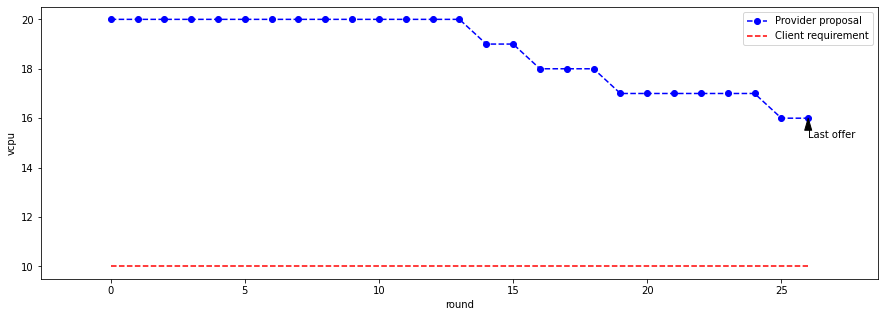

In [23]:
visualize_parameter(steps,vcpu,client_requirement[0],'vcpu')

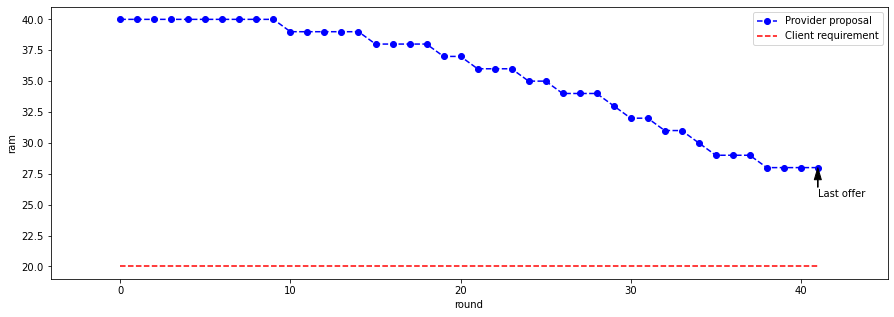

In [10]:
visualize_parameter(steps,ram,client_requirement[1],'ram')

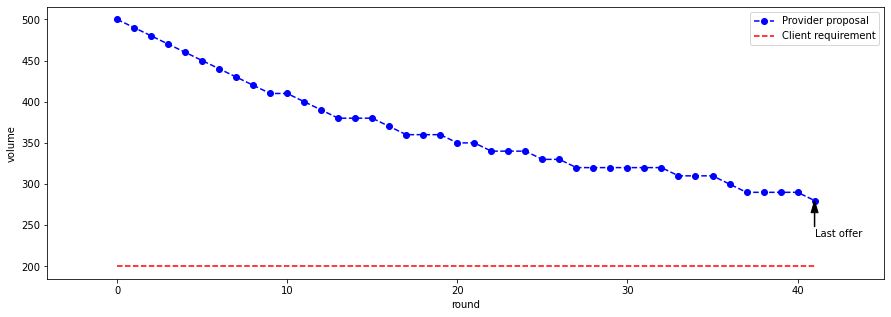

In [11]:
visualize_parameter(steps,volume,client_requirement[2],'volume')

0
5
10
15
-1


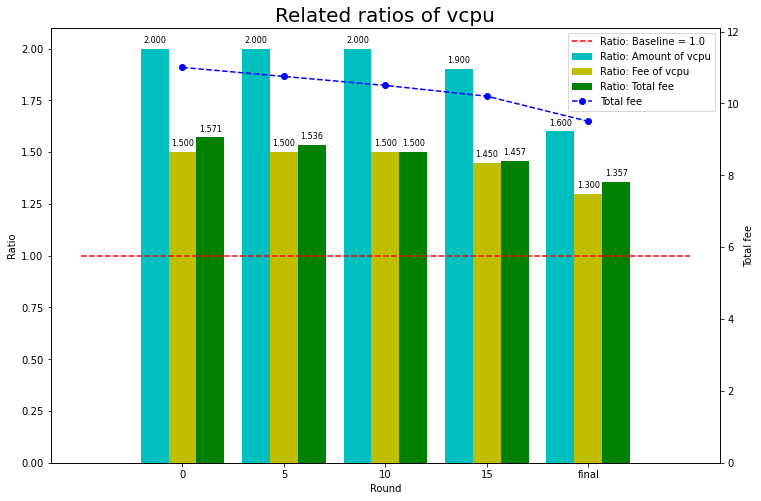

In [48]:
parameter = 'vcpu'
offer_list = [0,5,10,15,-1]
offer = vcpu
requirement = client_requirement
total_fee = total_fee
total_fee_old = total_fee_old
avg = avg_vcpu
avg_old = vcpu_avg_old
visulaize_gain(parameter,offer_list,offer,requirement,total_fee,total_fee_old,avg,avg_old)

0
5
10
15
-1


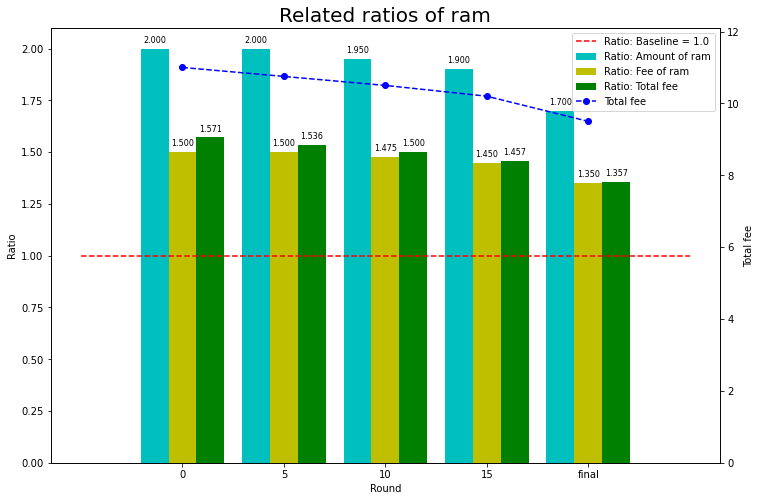

In [49]:
parameter = 'ram'
offer_list = [0,5,10,15,-1]
offer = ram
requirement = client_requirement
total_fee = total_fee
total_fee_old = total_fee_old
avg = avg_ram
avg_old = ram_avg_old
visulaize_gain(parameter,offer_list,offer,requirement,total_fee,total_fee_old,avg,avg_old)

0
5
10
15
-1


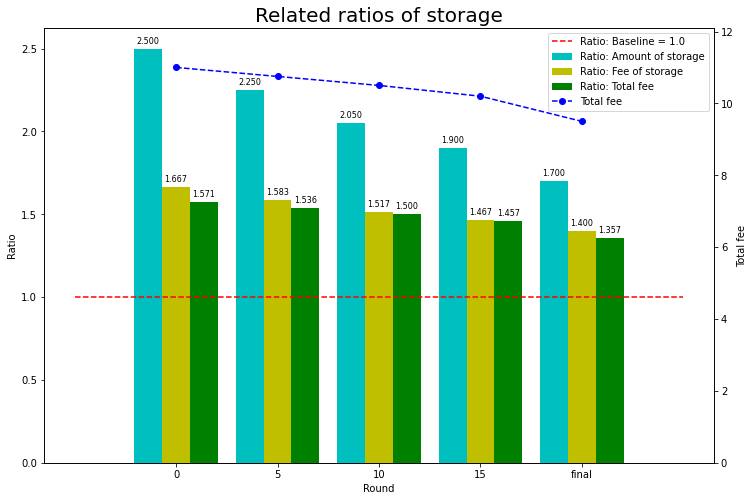

In [50]:
parameter = 'storage'
offer_list = [0,5,10,15,-1]
offer = volume
requirement = client_requirement
total_fee = total_fee
total_fee_old = total_fee_old
avg = avg_volume
avg_old = volume_avg_old
visulaize_gain(parameter,offer_list,offer,requirement,total_fee,total_fee_old,avg,avg_old)